In [1]:
from c3po.control.envelopes import *
from c3po.cobj.component import ControlComponent as CtrlComp
from c3po.cobj.group import ComponentGroup as CompGroup
from c3po.control.control import Control as Control
from c3po.control.control import ControlSet as ControlSet

from c3po.control.generator import Device as Device
from c3po.control.generator import AWG as AWG
from c3po.control.generator import Mixer as Mixer
from c3po.control.generator import Generator as Generator

from c3po.utils.tf_utils import *
from c3po.utils.hamiltonians import resonator as resonator
from c3po.cobj.component import *

from c3po.main.model import Model as mdl
from c3po.optimizer.optimizer import Optimizer as Opt
from c3po.simulation.simulator import Simulator as Sim

import uuid
import copy
import pickle

import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
%matplotlib notebook

#########################
# USER FRONTEND SECTION #
#########################

qubit1_freq = 5e9*2*np.pi
qubit2_freq = 5.25e9*2*np.pi
qubit_anhar = -300e6 *2*np.pi
qubit_lvls = 2

mV_to_Amp = 2e9*np.pi

drive_amp = (qubit2_freq - qubit1_freq)/mV_to_Amp

U_goal = tf.constant([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, -1]], dtype=tf.complex128)

##########################
#    END USER SECTION    #
##########################

<IPython.core.display.Javascript object>


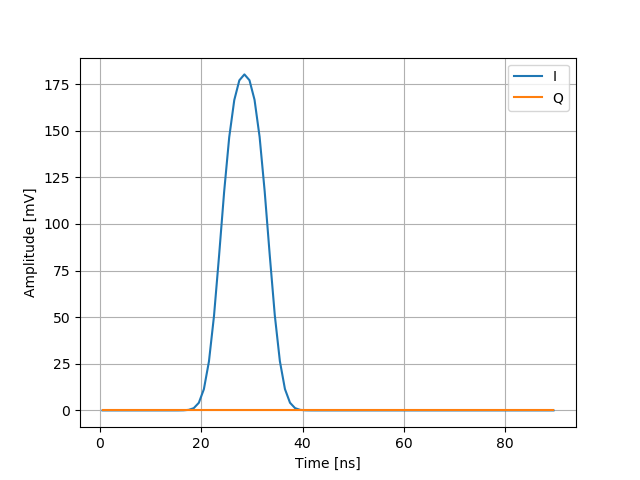

<IPython.core.display.Javascript object>

In [4]:
env_group = CompGroup()
env_group.name = "env_group"
env_group.desc = "group containing all components of type envelop"


flattop_params1 = {
    'amp' : drive_amp,
    'T_up' : 7e-9,
    'T_down' : 50e-9,
    'xy_angle' : 0.0,
    'freq_offset' : 0e6 * 2 * np.pi
}

params_bounds = {
    'amp' : [10e-3, 350e-3],
    'T_up' : [3e-9, 87e-9],
    'T_down' : [3e-9, 87e-9],
    'xy_angle' : [-np.pi, np.pi],
    'freq_offset' : [-0.2e9 * 2 * np.pi, 0.2e9 * 2 * np.pi]
}

def my_flattop(t, params):
    t_up = tf.cast(params['T_up'], tf.float64)
    t_down = tf.cast(params['T_down'], tf.float64)
    T2 = tf.maximum(t_up, t_down)
    T1 = tf.minimum(t_up, t_down)
    return (1 + tf.math.erf((t - T1) / 3e-9)) / 2 * \
            (1 + tf.math.erf((-t + T2) / 3e-9)) / 2


p1 = CtrlComp(
    name = "pulse1",
    desc = "flattop comp 1 of signal 1",
    shape = my_flattop,
    params = flattop_params1,
    bounds = params_bounds,
    groups = [env_group.get_uuid()]
)

env_group.add_element(p1)

carr_group = CompGroup()
carr_group.name = "carr_group"
carr_group.desc = "group containing all components of type carrier"


carrier_parameters = {
    'freq' : 0 # Hacking a DC signal for now.
}

carr = CtrlComp(
    name = "carrier",
    desc = "Frequency of the local oscillator",
    params = carrier_parameters,
    groups = [carr_group.get_uuid()]
)
carr_group.add_element(carr)

comps = []
comps.append(p1)
comps.append(carr)


ctrl = Control()
ctrl.name = "control1"
ctrl.t_start = 0.0
ctrl.t_end = 90e-9
ctrl.comps = comps


ctrls = ControlSet([ctrl])

opt_map = {
    'amp' : [(ctrl.get_uuid(), p1.get_uuid())],
    'T_up' : [(ctrl.get_uuid(), p1.get_uuid())],
    'T_down' : [(ctrl.get_uuid(), p1.get_uuid())],
#   'freq_offset' : [(ctrl.get_uuid(), p1.get_uuid())]
}
awg = AWG()
mixer = Mixer()

# awg.options = "drag"
# opt_map['detuning'] =  [(ctrl.get_uuid(), p1.get_uuid())]
# flattop_params1['detuning'] = -300e6 * 2 * np.pi
# params_bounds['detuning'] =  [-500e6 * 2 * np.pi, -100e6 * 2 * np.pi]


devices = {
    "awg" : awg,
    'mixer' : mixer
}

resolutions = {
    "awg" : 1e9,
    "sim" : 5e10
}


resources = [ctrl]


resource_groups = {
    "env" : env_group,
    "carr" : carr_group
}


gen = Generator(devices, resolutions, resources, resource_groups)
output = gen.generate_signals()

In [5]:
q1 = Qubit(
    name = "Q1",
    desc = "Qubit 1",
    comment = "The flux-tunable qubit.",
    freq = qubit1_freq,
    delta = qubit_anhar,
    hilbert_dim = qubit_lvls
    )

q2 = Qubit(
    name = "Q2",
    desc = "Qubit 2",
    comment = "The fixed frequency qubit.",
    freq = qubit2_freq,
    delta = 1.1*qubit_anhar,
    hilbert_dim = qubit_lvls
    )

coupling12 = Coupling(
    name = "g12",
    desc = "Coupling 1-2",
    comment = "Coupling between qubit 1 and 2.",
    strength = 200e6 * 2 * np.pi,
    connected = [q1.name, q2.name]
    )

drive = Drive(
    name = "D1",
    desc = "Drive 1",
    comment = "Flux drive line 1 on qubit 1",
    Hamiltonian = resonator,
    connected = [q1.name]
    )

chip_elements = [
    q1,
    q2,
    coupling12,
    drive
     ]

two_qubit_chip = mdl(chip_elements, mV_to_Amp)


rechenknecht = Opt()

opt_params = ctrls.get_corresponding_control_parameters(opt_map)
rechenknecht.opt_params = opt_params

In [9]:
sim = Sim(two_qubit_chip, gen, ctrls)

rechenknecht.simulate_noise = True

def evaluate_signals(pulse_params, opt_params):
    model_params = sim.model.params
    U = sim.propagation(pulse_params, opt_params, model_params)
    error = 1 + tf.cast(U[3][3] / U[2][2], tf.float64)
    return error*error

# exp_sim = Sim(real_model, gen, ctrls)

# def experiment_evaluate(pulse_params, opt_params):
#     model_params = exp_sim.model.params
#     U = exp_sim.propagation(pulse_params, opt_params, model_params)
#     psi_actual = tf.matmul(U, psi_init)
#     overlap = tf.matmul(psi_goal, psi_actual)
#     return 1-tf.cast(tf.linalg.adjoint(overlap)*overlap, tf.float64)

# def match_model_psi(model_params, opt_params, pulse_params, result):

#     U = sim.propagation(pulse_params, opt_params, model_params)

#     psi_actual = tf.matmul(U, psi_init)
#     overlap = tf.matmul(psi_goal, psi_actual)
#     diff = (1-tf.cast(tf.linalg.adjoint(overlap)*overlap, tf.float64)) - result

#     model_error = diff * diff

#     return model_error

In [7]:
U_goal[3][3]

<tf.Tensor: id=338, shape=(), dtype=complex128, numpy=(-1+0j)>

<IPython.core.display.Javascript object>


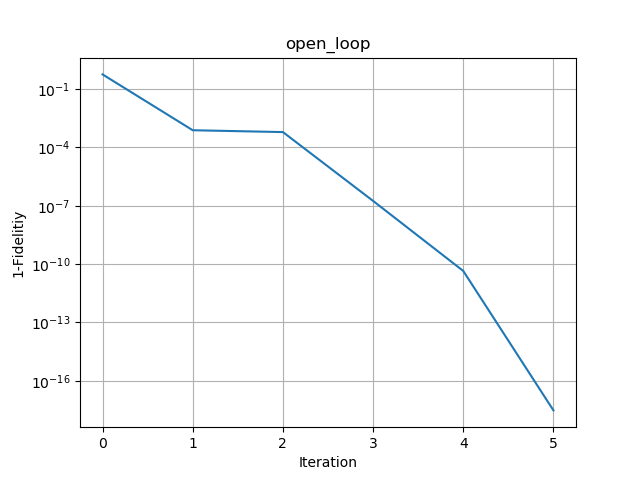

In [10]:
settings = {} #'maxiter': 1}

rechenknecht.optimize_controls(
    controls = ctrls,
    opt_map = opt_map,
    opt = 'lbfgs',
    settings = settings,
    calib_name = 'open_loop',
    eval_func = evaluate_signals,
    )

In [13]:
min(mixer.ts)

<tf.Tensor: id=3398119, shape=(), dtype=float64, numpy=1e-11>

In [ ]:
plt.close('all')

In [ ]:
initial_spread = [5e-3, 0.1, 20e6*2*np.pi, 20e6*2*np.pi]

opt_settings = {
    'CMA_stds': initial_spread,
    'maxiter' : 20,
#    'ftarget' : 1e-4,
    'popsize' : 5
}

rechenknecht.optimize_controls(
    controls = ctrls,
    opt_map = opt_map,
    opt = 'cmaes',
#    opt = 'tf_grad_desc',
    settings = opt_settings,
    calib_name = 'closed_loop',
    eval_func = experiment_evaluate
    )

In [ ]:
settings = {'maxiter': 100}

rechenknecht.learn_model(
    optimize_model,
    eval_func = match_model_psi,
    settings = settings,
    learn_from = 'closed_loop'
    )

In [ ]:
print(initial_model.params)
print(optimize_model.params)
print(real_model.params)

In [ ]:
initial_model.params_desc

In [ ]:
A = []
A.append([])

In [ ]:
A[0]

In [ ]:
sim.